# Resampling techniques
Notebook to explore the optimal resampling techniques for data imbalance. The workflow is the following:
1. Assessment of various resampling techniques 
- Undersampling and upweighting (at various ratios)
- Undersampling and oversampling
- BalanceCascade or EasyEnsemble approach
- Self-paced ensemble (Self-paced Ensemble for Highly Imbalanced Massive Data Classification
- Manually-prepared undersampling (reference: Solving the class imbalance problem using ensemble algorithm: application of screening for aortic dissection)
- Hybrid approach (ref: Classifier Ensemble Design for Imbalanced Data Classification: A
Hybrid Approach)

2. Visualization of results and deeper dive 
- Visualization of decision boundaries
- Train and test learning curves
- Weight of different features
- Ensemble models for performance improvement


3. Propose a final high-performing method> potentially with active learning

In [90]:
# Import all needed libraries
import os
import importlib
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score
import matplotlib as plt
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from auxFuns.EDA import * 
from auxFuns.modelling import *

In [79]:
import auxFuns.modelling
importlib.reload(auxFuns.modelling)

<module 'auxFuns.modelling' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\modelling.py'>

In [92]:
# Loading of the data
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_df_v2 = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup_seasons_prevTest.csv',low_memory=False)
rsv_predictors_df_v2 = make_it_categorical_v2(rsv_predictors_df_v2)
# summary_function_rsv(rsv_predictors_df_v2)

# Extract a reduced sample of the data for modelling
# sample_size = 80000
# sample_v2_df = rsv_predictors_df_v2.sample(n = sample_size, random_state=42)

sample_v2_df = rsv_predictors_df_v2

In [93]:
selected_features_v0 = ['sex', 'marital_status', 'race','patient_regional_location', 'age_group',
                     'Acute_upper_respiratory_infection','Influenza','Pneumonia','Bronchitis','Symptoms_and_signs__digestive_system_and_abdomen','General_symptoms_and_signs','any_symptom',
                     'COPD','AIDS','Asthma_chronic','CCI',
                     'sine','cosine','calendar_year', 
                     'healthcare_seeking', 'influenza_vaccine',
                     'n_symptoms','prev_positive_rsv','previous_test_daydiff','n_immunodeficiencies', 
                     'tumor_indicator','tumor_last_year',
                     'season',
                     'n_tests_that_day']
selected_features_v1 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'season','multiple_tests']
selected_features_v2 = ['n_tests_that_day', 'sine','cosine', 'previous_test_daydiff',
                     'Bronchitis', 'CCI',
                     'Acute_upper_respiratory_infection', 'n_immunodeficiencies', 'n_symptoms',
                     'healthcare_seeking', 
                     'General_symptoms_and_signs', 'prev_positive_rsv', 'Influenza',
                     'key_comorbidities','Pneumonia',
                     'season','multiple_tests']
selected_features_v3 = selected_features_v2 + ['race', 'age_group','marital_status','sex',
                                                    'patient_regional_location','calendar_year']

selected_features_v1.append('RSV_test_result')
selected_features_v2.append('RSV_test_result')
selected_features_v3.append('RSV_test_result')

In [94]:
df1 = sample_v2_df[selected_features_v3]
input_test_size = 0.2
random_seed = 42

In [23]:
# Train a base model for model performance comparison

X_train, y_train, X_test, y_test, sample_weights, preprocessor_rsv = preprocess_and_resample_rsv(
    df1, input_test_size = input_test_size, random_seed = random_seed, resampling_technique = None)

model_class = LogisticRegression(random_state= random_seed, class_weight= None)
param_grid = {
    'C': [0.01, 0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
target_scorer = make_scorer(f1_score, average='binary', pos_label = 'Positive')
n_cv_folds = 5

model_baseline = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train, y_train = y_train)
optimal_threshold = find_optimal_moving_threshold(model = model_baseline, X_test = X_test, y_test = y_test)


__,__,__,__,__,__,__,__ = calculate_performance_metrics_rsv(trained_model = model_baseline, X_test = X_test, y_test = y_test,
                                                         threshold = optimal_threshold)

Resampling method chosen:

None
Training model ... LogisticRegression(random_state=42)
Best training parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best training f1-score:  0.3731412426726811
Optimal threshold: 0.16
Optimal f1: 0.36389684813753587


AUC Score: 0.793110410922313
Precision / Positive predictive value: 0.7604790419161677
Specificity: 0.9976020622264852
Recall / sensitivity: 0.2391713747645951
Negative predictive value: 0.9762980346142563
Accuracy: 0.9742040436904486
F-1: 0.36389684813753587
Precision-Recall AUC: 0.35006604422088966


# 1. Downsampling and upweighting at different ratios

Build the downsampling and upweighting approach following various sampling ratios and evaluating their performance.

In [48]:
X = df1.drop('RSV_test_result', axis = 1)
y = df1['RSV_test_result']
# workflow for preprocessing is:
# i) train-test split
# ii) resample train data
# iii) transform X data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= input_test_size, random_state=random_seed,
                                                        stratify= y)
preprocessor_rsv = build_preprocessor(X_train = X_train)

# Trying various ratios for downsampling and upweigthing and plotting the results
ratio_values = [x / 10 for x in range(1, 11)]
auc_scores = []
f1_scores = []
recalls = []
precisions = []
optimal_thresholds = []

for r in ratio_values:
    print('\n----------------------------------------------')
    print(f'Downsampling and upweighting at ratio: {r}')

    # Resample and preprocess the data
    X_train_up, y_train_up, sample_weights_upweight = downsampling_upweighting(X_train = X_train, y_train = y_train, 
                                                                ratio_maj_min = r, random_seed = random_seed)
    
    X_train_transformed = preprocessor_rsv.fit_transform(X_train_up)
    X_test_transformed = preprocessor_rsv.transform(X_test)

    # Train a new model on the new data
    model_new = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train_up, sample_weights = sample_weights_upweight)
    
    # Obtain performance metrics
    optimal_threshold = find_optimal_moving_threshold(model = model_new, X_test = X_test_transformed, y_test = y_test)
    auc_score, precision, recall, specificity, npv, accuracy, f1, precision_recall_auc = calculate_performance_metrics_rsv(trained_model = model_new, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold)
    auc_scores.append(auc_score)
    f1_scores.append(f1)
    recalls.append(recall)
    precisions.append(precision)
    optimal_thresholds.append(optimal_threshold)



----------------------------------------------
Downsampling and upweighting at ratio: 0.1
Training model ... LogisticRegression(random_state=42)
Best training parameters:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best training f1-score:  0.8092018396617331
Optimal threshold: 0.99
Optimal f1: 0.3513097072419107


AUC Score: 0.7709286397878616
Precision / Positive predictive value: 0.9661016949152542
Specificity: 0.9997602062226485
Recall / sensitivity: 0.21468926553672316
Negative predictive value: 0.9756054756054756
Accuracy: 0.9755403207064839
F-1: 0.3513097072419107
Precision-Recall AUC: 0.3196070180374756

----------------------------------------------
Downsampling and upweighting at ratio: 0.2
Training model ... LogisticRegression(random_state=42)
Best training parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Best training f1-score:  0.7865587322067402
Optimal threshold: 0.87
Optimal f1: 0.3413400758533502


AUC Score: 0.7834977173867763
Precision / Positiv

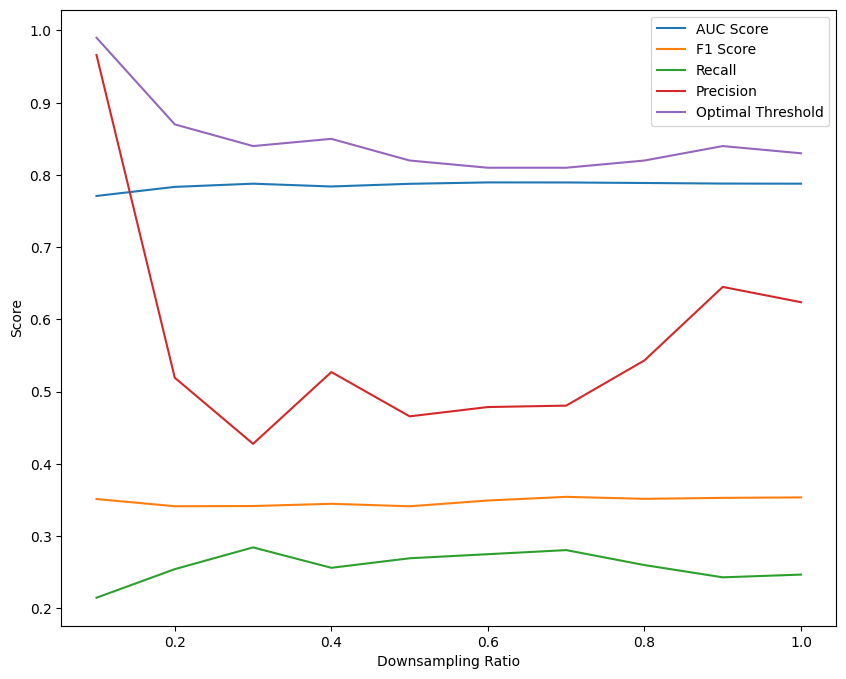

In [49]:
# Plot metrics
plt.figure(figsize=(5, 4))
plt.plot(ratio_values, auc_scores, label='AUC Score')
plt.plot(ratio_values, f1_scores, label='F1 Score')
plt.plot(ratio_values, recalls, label='Recall')
plt.plot(ratio_values, precisions, label='Precision')
plt.plot(ratio_values, optimal_thresholds, label='Optimal Threshold')
plt.xlabel('Downsampling Ratio')
plt.ylabel('Score')
plt.legend()
plt.show()

# 2. Downsampling and oversampling

In [87]:
X = df1.drop('RSV_test_result', axis = 1)
y = df1['RSV_test_result']
# workflow for preprocessing is:
# i) train-test split
# ii) resample train data
# iii) transform X data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= input_test_size, random_state=random_seed,
                                                        stratify= y)
preprocessor_rsv = build_preprocessor(X_train = X_train)

# Trying various ratios for downsampling and upweigthing and plotting the results
ratio_values = [x / 10 for x in range(1, 11)]
auc_scores = []
f1_scores = []
recalls = []
precisions = []
optimal_thresholds = []

for r in ratio_values:
    print('\n----------------------------------------------')
    print(f'Downsampling and upweighting at ratio: {r}')

    # Resample and preprocess the data
    X_train_up, y_train_up = upsample_downsample(X_train = X_train, y_train = y_train, 
                                                                ratio_maj_min = r, random_seed = random_seed)
    
    X_train_transformed = preprocessor_rsv.fit_transform(X_train_up)
    X_test_transformed = preprocessor_rsv.transform(X_test)

    # Train a new model on the new data
    model_new = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train_up)
    
    # Obtain performance metrics
    optimal_threshold = find_optimal_moving_threshold(model = model_new, X_test = X_test_transformed, y_test = y_test)
    auc_score, precision, recall, specificity, npv, accuracy, f1, precision_recall_auc = calculate_performance_metrics_rsv(trained_model = model_new, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold)
    auc_scores.append(auc_score)
    f1_scores.append(f1)
    recalls.append(recall)
    precisions.append(precision)
    optimal_thresholds.append(optimal_threshold)



----------------------------------------------
Downsampling and upweighting at ratio: 0.1
Training model ... LogisticRegression(random_state=42)
Best training parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best training f1-score:  0.9535545200891825
Optimal threshold: 0.99
Optimal f1: 0.31578947368421056


AUC Score: 0.780747991755339
Precision / Positive predictive value: 0.6453488372093024
Specificity: 0.99634314489539
Recall / sensitivity: 0.20903954802259886
Negative predictive value: 0.9753521126760564
Accuracy: 0.9720543806646526
F-1: 0.31578947368421056
Precision-Recall AUC: 0.30003041624755267

----------------------------------------------
Downsampling and upweighting at ratio: 0.2
Training model ... LogisticRegression(random_state=42)
Best training parameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best training f1-score:  0.9137059671906437
Optimal threshold: 0.96
Optimal f1: 0.3218997361477573


AUC Score: 0.7881006515187898
Precision / Positive

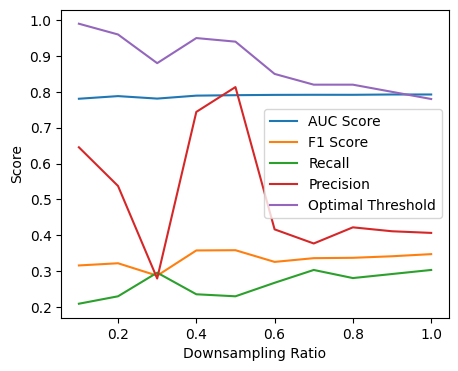

In [88]:
# Plot metrics
plt.figure(figsize=(5, 4))
plt.plot(ratio_values, auc_scores, label='AUC Score')
plt.plot(ratio_values, f1_scores, label='F1 Score')
plt.plot(ratio_values, recalls, label='Recall')
plt.plot(ratio_values, precisions, label='Precision')
plt.plot(ratio_values, optimal_thresholds, label='Optimal Threshold')
plt.xlabel('Downsampling Ratio')
plt.ylabel('Score')
plt.legend()
plt.show()

# 3. Imblearn built-in ensemble resamplers
- EasyEnsembleClassifier
- BalancedBaggingClassifier

In [ ]:
def resample_with_ensemble(X_train, y_train, random_seed=42):
    bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                    sampling_strategy='auto',
                                    replacement=False,
                                    random_state=random_seed)
    bbc.fit(X_train, y_train)
    return bbc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= input_test_size, random_state=random_seed,
                                                        stratify= y)
preprocessor_rsv = build_preprocessor(X_train = X_train)
X_train_transformed = preprocessor_rsv.fit_transform(X_train_up)
X_test_transformed = preprocessor_rsv.transform(X_test)

bbc_model = resample_with_ensemble(X_train_transformed, y_train)
predictions = bbc_model.predict(X_test_transformed)

optimal_threshold = find_optimal_moving_threshold(bbc_model, X_test_transformed, y_test)
auc_score, precision, recall, specificity, npv, accuracy, f1, precision_recall_auc = calculate_performance_metrics_rsv(trained_model = bbc_model, X_test = X_test_transformed, y_test = y_test,
                                                         threshold = optimal_threshold)